<a href="https://colab.research.google.com/github/JianfengMI/MLprojects/blob/main/Factor_GAN_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Factor-GAN model for stock price prediction

Based on the Factor-GAN framework described in the 2024 PLOS One paper (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0306094).This architecture uses an LSTM-based generator to predict stock returns from financial factors (e.g., 70 firm characteristics like beta, valuation, etc.) and a 1D CNN-based discriminator for adversarial training. The model employs Wasserstein GAN (WGAN) loss to improve stability and address issues like vanishing gradients.

Key assuptions:


*   **Inputs:** Firm characteristics (factors) as a tensor of shape (batch_size, 1, num_factors), where num_factors=70 by default (as per the paper). Outputs are predicted stock returns (scalar per sample).
*   **Data Preparation:** You'll need historical stock data with factors. Use libraries like yfinance or pandas to fetch and preprocess (e.g., standardize factors to [-1, 1]). The code assumes you have tensors for factors (X) and real returns (y).
*   **Training:** Adversarial setup with WGAN and gradient penalty for stability. No explicit noise input to the generator (firm characteristics serve as the conditioning input).
*   **Limitations:** This is a simplified implementation for educational purposes. Tune hyperparameters, add dropout if needed, and validate on real data to avoid overfitting.
*   **Dependencies:** PyTorch (e.g., torch, torch.nn, torch.optim).




## Model Architecture

In [ ]:
# import pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable, grad

In [ ]:
# build a class of generator
class Generator(nn.Module):
    def __init__(self, input_size=70, hidden_size=500):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        # x: (batch_size, seq_len=1, input_size=70)
        out, _ = self.lstm(x)
        out = self.leaky_relu(out[:,-1,:]) # take last timestep
        out = self.fc(out)
        return out

In [ ]:
# build a class of discriminator
class Discriminator(nn.Module):
    def __init__(self, input_length=71): # 70 factors + 1 return
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        flatten_size = 128 * input_length
        self.fc1 = nn.Linear(flatten_size, 220)
        self.fc2 = nn.Linear(220, 1) # WGAN output: scalar (no sigmoid)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        # x: (batch_size, 1, input_length=71) # treat features as 1D sequence
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        x = x.view(x.size(0), -1) # Flatten
        x = self.leaky_relu(self.fc1(x))
        out = self.fc2(x)
        return out

In [ ]:
# gradient penalty for WGAN-GP stability
def compute_gradient_penalty(discriminator, real_data, fake_data, device="cpu"):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake data
    alpha = torch.rand((real_data.size(0), 1, 1), device=device).expand_as(real_data)
    # Get random interpolation between real and fake data
    interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates).to(device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

## Sample training

How It Works

Generator (LSTM): Takes firm factors as input and predicts the next-period return. The LSTM captures temporal dependencies, even with seq_len=1 (extendable for multi-step).

Discriminator (1D CNN): Treats the concatenated factors + return as a 1D sequence for classification. Conv layers extract features; FC layers output a scalar for WGAN.

Financial Factors Incorporation: Factors are direct inputs to the generator and concatenated with returns for the discriminator, ensuring predictions align with factor-driven market dynamics.

Prediction Usage: After training, use the generator standalone for inference: predicted_returns = generator(factors_tensor).

Extensions: For better performance, add noise to generator input (e.g., concatenate random z). Test on datasets like Chinese A-shares (as in the paper) or S&P 500.

## generate synthetic inputs to try this model

In [ ]:
# import libraries
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [ ]:
# parameters for synthetic data
num_samples = 10000
num_factors = 70
batch_size = 64
seq_len = 1 # single timestip as per model
return_std = 0.02 # typical daily return volatility
factor_corr = 0.1 # slight correlation between factors

# set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# generate synthetic factors with slight correlations
def generate_factors(num_samples, num_factors, corr):
  # create a covariance matrix with diagonal=1 and off_diagonal=corr
  cov_matrix = np.ones((num_factors, num_factors)) * corr
  np.fill_diagonal(cov_matrix, 1.0)
  # generate multivariate normal factors
  factors = np.random.multivariate_normal(
      mean=np.zeros(num_factors),
      cov=cov_matrix,
      size=num_samples
      )
  # reshape to (num_samples, seq_len=1,                                                                                                                                             s)
  factors = factors.reshape(num_samples, seq_len, num_factors)
  return torch.tensor(factors, dtype=torch.float32)

In [ ]:
# generate synthetic returns with weak factor dependency
def generate_returns(factors):
  # Use first 5 factors to influence returns (simulating key drivers like beta, momentum)
  factor_weights = torch.tensor([0.1,0.08,0.06,0.04,0.02] + [0.0] * (num_factors - 5), dtype=torch.float32)

  # compute base return as weighted sum of factors + noise
  base_return = torch.sum(factors * factor_weights, dim=2)
  noise = torch.normal(mean=0.0, std=return_std, size=(num_samples, 1))
  returns = base_return + noise
  return returns

In [ ]:
# generate data
factors_tensor = generate_factors(num_samples, num_factors, factor_corr)
returns_tensor = generate_returns(factors_tensor)

In [ ]:
# create DataLoader
dataset = TensorDataset(factors_tensor, returns_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
factors_tensor

tensor([[[ 1.5778, -1.7551, -0.1313,  ...,  0.4390,  0.5484, -1.7935]],

        [[-0.5176, -0.7908, -0.6018,  ..., -0.2267, -0.2083,  1.1381]],

        [[-0.8448,  0.6326, -0.3808,  ..., -0.6374, -0.7323, -0.0260]],

        ...,

        [[-0.8692, -0.2255, -0.6441,  ..., -0.2872,  0.1428, -0.8124]],

        [[ 0.9181,  0.4629,  0.2618,  ..., -0.3947, -0.4677, -0.7997]],

        [[ 0.3550,  0.7932,  0.5190,  ...,  0.7084,  0.2898, -0.3465]]])

In [ ]:
# Example: Print shapes and sample data
print(f"Factors shape: {factors_tensor.shape}")  # (10000, 1, 70)
print(f"Returns shape: {returns_tensor.shape}")  # (10000, 1)
print(f"Sample factors (first sample): {factors_tensor[0, 0, :5]}")  # First 5 factors
print(f"Sample return (first sample): {returns_tensor[0]}")

Factors shape: torch.Size([10000, 1, 70])
Returns shape: torch.Size([10000, 1])
Sample factors (first sample): tensor([ 1.5778, -1.7551, -0.1313,  0.1422,  0.1634])
Sample return (first sample): tensor([0.0570])


## train the model

In [ ]:
# setup training
# hyperparameters
num_epochs = 100
batch_size = 64
lr = 0.0002
n_critic =5 # train discriminator more often
lambda_gp = 10 # Gradient penalty weight
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize models
generator = Generator(input_size=70, hidden_size=500).to(device)
discriminator = Discriminator(input_length=71).to(device)

# optimizers (RMSprop for WGAN stability)
optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)

In [ ]:
# track losses
g_losses = []
d_losses = []

In [ ]:
# training loop
for epoch in range(num_epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    for i, (factors, real_returns) in enumerate(train_loader):
        factors = factors.to(device)
        real_returns = real_returns.to(device)
        batch_size_current = factors.size(0)

        # Prepare real inputs: concatenate factors and returns
        real_inputs = torch.cat((factors, real_returns.unsqueeze(1)), dim=2)

        # Train Discriminator
        for _ in range(n_critic):
            optimizer_D.zero_grad()
            fake_returns = generator(factors)
            fake_inputs = torch.cat((factors, fake_returns.unsqueeze(1)), dim=2)
            real_validity = discriminator(real_inputs).mean()
            fake_validity = discriminator(fake_inputs).mean()
            gp = compute_gradient_penalty(discriminator, real_inputs, fake_inputs, device)
            d_loss = -real_validity + fake_validity + lambda_gp * gp
            d_loss.backward()
            optimizer_D.step()
            epoch_d_loss += d_loss.item()

        # Train Generator
        optimizer_G.zero_grad()
        fake_returns = generator(factors)
        fake_inputs = torch.cat((factors, fake_returns.unsqueeze(1)), dim=2)
        g_loss = -discriminator(fake_inputs).mean()
        g_loss.backward()
        optimizer_G.step()
        epoch_g_loss += g_loss.item()

    # Average losses
    g_losses.append(epoch_g_loss / len(train_loader))
    d_losses.append(epoch_d_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_losses[-1]:.4f} | G Loss: {g_losses[-1]:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100] | D Loss: 0.2591 | G Loss: -1.9210
Epoch [2/100] | D Loss: 0.0879 | G Loss: -3.4830
Epoch [3/100] | D Loss: 0.0747 | G Loss: -3.9717
Epoch [4/100] | D Loss: 0.0634 | G Loss: -3.9707
Epoch [5/100] | D Loss: 0.0505 | G Loss: -4.0871
Epoch [6/100] | D Loss: 0.0477 | G Loss: -4.2207
Epoch [7/100] | D Loss: 0.0445 | G Loss: -4.2257
Epoch [8/100] | D Loss: 0.0395 | G Loss: -4.4409
Epoch [9/100] | D Loss: 0.0375 | G Loss: -4.6075
Epoch [10/100] | D Loss: 0.0346 | G Loss: -4.5372
Epoch [11/100] | D Loss: 0.0321 | G Loss: -4.6026
Epoch [12/100] | D Loss: 0.0315 | G Loss: -4.5746
Epoch [13/100] | D Loss: 0.0291 | G Loss: -4.7637
Epoch [14/100] | D Loss: 0.0277 | G Loss: -4.8550
Epoch [15/100] | D Loss: 0.0275 | G Loss: -4.9441
Epoch [16/100] | D Loss: 0.0260 | G Loss: -4.9953
Epoch [17/100] | D Loss: 0.0259 | G Loss: -4.9782
Epoch [18/100] | D Loss: 0.0250 | G Loss: -5.0141
Epoch [19/100] | D Loss: 0.0231 | G Loss: -5.0464
Epoch [20/100] | D Loss: 0.0235 | G Loss: -5.1628
Epoch [21

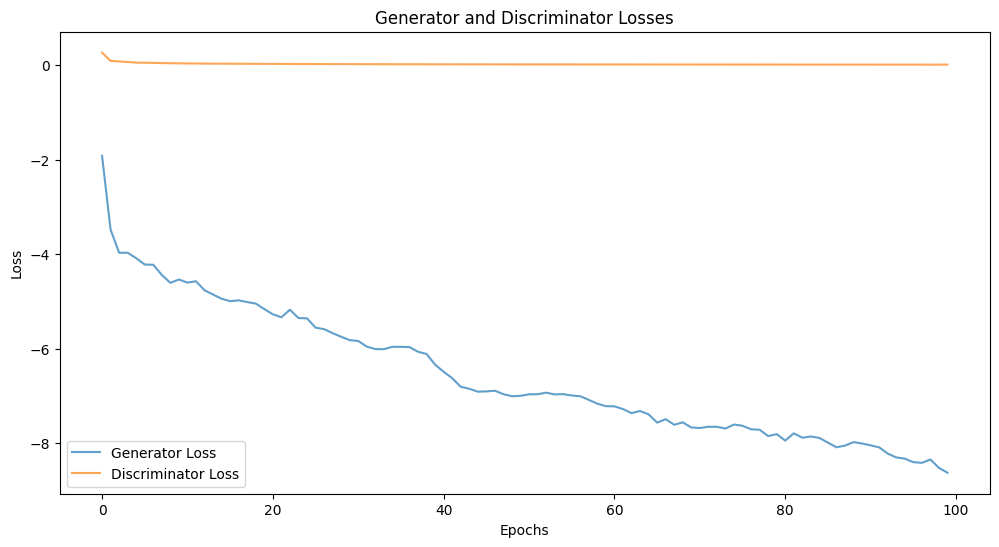

In [ ]:
# plot the g_losses and d_losses over epochs
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(g_losses, label='Generator Loss', alpha=0.7)
plt.plot(d_losses, label='Discriminator Loss', alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()
plt.show()

In [ ]:
# save model
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

Starting evaluation...
predicted_returns type: <class 'numpy.ndarray'>
predicted_returns shape: (100, 1)
Slice tensor type: <class 'torch.Tensor'>
Slice tensor device: cpu
Detached type: <class 'torch.Tensor'>
CPU tensor type: <class 'torch.Tensor'>
real_returns type: <class 'numpy.ndarray'>
real_returns shape: (100, 1)
First 5 real returns: [ 0.05698701 -0.10902616 -0.10764046 -0.16105199  0.11278971]


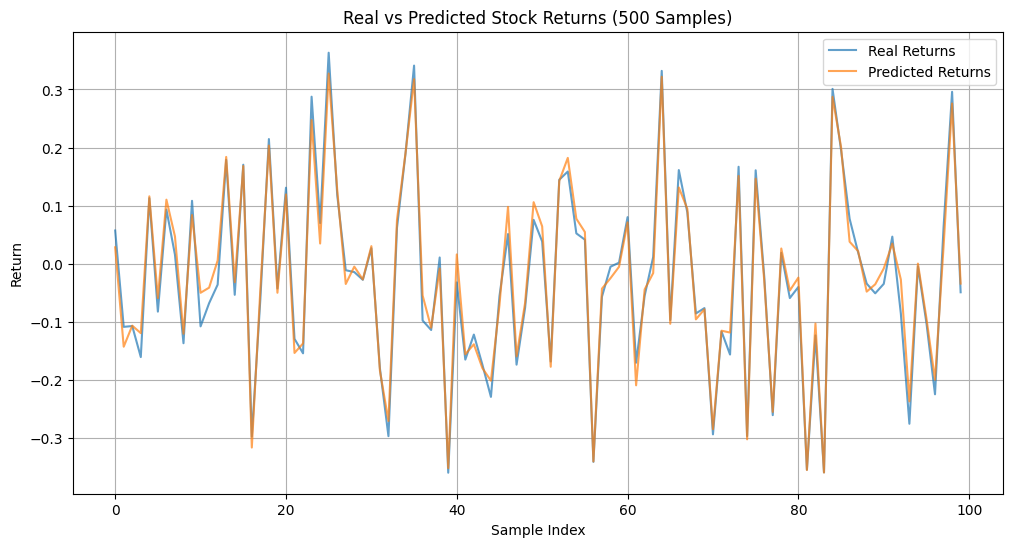

Test MSE: 0.000502
Plot saved and displayed!


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming generator, factors_tensor, returns_tensor, and device are defined from training
# If not, load them: e.g., factors_tensor = torch.load('synthetic_factors.pt').to(device)

print("Starting evaluation...")

# --- Evaluate and Visualize (Bulletproof Version) ---
generator.eval()
with torch.no_grad():
    test_factors = factors_tensor[:100].to(device)
    predicted_returns = generator(test_factors).detach().cpu().numpy()
    print(f"predicted_returns type: {type(predicted_returns)}")  # Should be <class 'numpy.ndarray'>
    print(f"predicted_returns shape: {predicted_returns.shape}")  # (500, 1)

    # Fixed assignment with () and error handling
    try:
        slice_tensor = returns_tensor[:100]
        print(f"Slice tensor type: {type(slice_tensor)}")  # <class 'torch.Tensor'>
        print(f"Slice tensor device: {slice_tensor.device}")

        detached = slice_tensor.detach()  # Call the method
        print(f"Detached type: {type(detached)}")  # <class 'torch.Tensor'>

        cpu_tensor = detached.cpu()
        print(f"CPU tensor type: {type(cpu_tensor)}")  # <class 'torch.Tensor'>

        real_returns = cpu_tensor.numpy()  # Convert to NumPy
        print(f"real_returns type: {type(real_returns)}")  # <class 'numpy.ndarray'>
        print(f"real_returns shape: {real_returns.shape}")  # (500, 1)

        # Test slicing to confirm
        print(f"First 5 real returns: {real_returns[:5].flatten()}")

    except AttributeError as e:
        print(f"AttributeError caught: {e}")
        print("Fix: Ensure .detach() has parentheses! Falling back to direct conversion.")
        real_returns = returns_tensor[:500].detach().cpu().numpy()  # One-liner fix
    except Exception as e:
        print(f"Unexpected error: {type(e).__name__}: {str(e)}")
        # Minimal fallback (assumes CPU)
        real_returns = returns_tensor[:500].detach().numpy()

# Now plot (only if real_returns is a NumPy array)
if isinstance(real_returns, np.ndarray):
    plt.figure(figsize=(12, 6))
    plt.plot(real_returns.flatten(), label='Real Returns', alpha=0.7)  # Flatten for 1D plot
    plt.plot(predicted_returns.flatten(), label='Predicted Returns', alpha=0.7)
    plt.title('Real vs Predicted Stock Returns (500 Samples)')
    plt.xlabel('Sample Index')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.savefig('returns_comparison_500.png', dpi=300, bbox_inches='tight')
    plt.show()

    # MSE
    mse = np.mean((real_returns - predicted_returns) ** 2)
    print(f"Test MSE: {mse:.6f}")
    print("Plot saved and displayed!")
else:
    print(f"real_returns is still invalid (type: {type(real_returns)}). Check the try block output above.")

In [ ]:
# calculate mse
mse = np.mean((real_returns - predicted_returns) ** 2)
print(f"Test MSE: {mse:.6f}")

Test MSE: 0.000502


# download stocks data by using Finrl

In [1]:
# install Finrl
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-3yr3c53x
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-3yr3c53x
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 9e8c38aa5b92bbf0e20f65fc611fd43b43196859
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-zh1idkou/elegantrl_fc87db0a8d154a4ebb1b8e01879dd26a
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-zh1idkou/elegantrl_fc87db0a8d154a4ebb1b8e01879dd26a
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 37aac1f592e1add9f9fd37ae8db1094656009b76
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/1

In [1]:
# import libries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS

import itertools
import warnings
warnings.filterwarnings("ignore")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2024-9-11'
TRADE_START_DATE = '2024-9-12'
TRADE_END_DATE = '2025-9-11'

In [3]:
symbols = ['aapl']

In [4]:
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = symbols).fetch_data()

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (4198, 8)


In [5]:
df_raw.head()

Price,date,close,high,low,open,volume,tic,day
0,2009-01-02,2.724325,2.733032,2.556514,2.578128,746015200,aapl,4
1,2009-01-05,2.839303,2.887335,2.783165,2.796974,1181608400,aapl,0
2,2009-01-06,2.792471,2.917055,2.773559,2.880430,1289310400,aapl,1
3,2009-01-07,2.732131,2.776861,2.709616,2.756147,753048800,aapl,2
4,2009-01-08,2.782865,2.796375,2.703011,2.714720,673500800,aapl,3


In [6]:
# preprocess data by using FeatureEngineer function
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

df = fe.preprocess_data(df_raw)

Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (4197, 8)
Successfully added vix
Successfully added turbulence index


In [7]:
df.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,2.724325,2.733032,2.556514,2.578128,746015200,aapl,4,0.000000,2.944416,2.619212,100.000000,66.666667,100.000000,2.724325,2.724325,39.189999,0.0
1,2009-01-05,2.839303,2.887335,2.783165,2.796974,1181608400,aapl,0,0.002580,2.944416,2.619212,100.000000,66.666667,100.000000,2.781814,2.781814,39.080002,0.0
2,2009-01-06,2.792471,2.917055,2.773559,2.880430,1289310400,aapl,1,0.001835,2.901000,2.669733,70.355481,45.847664,100.000000,2.785366,2.785366,38.560001,0.0
3,2009-01-07,2.732131,2.776861,2.709616,2.756147,753048800,aapl,2,-0.000728,2.880446,2.663669,50.429240,-30.767422,43.607889,2.772058,2.772058,43.389999,0.0
4,2009-01-08,2.782865,2.796375,2.703011,2.714720,673500800,aapl,3,-0.000086,2.868583,2.679855,60.227069,-8.239280,48.358048,2.774219,2.774219,42.560001,0.0


In [8]:
# drop off column tic
df = df.drop('tic', axis=1)

In [9]:
# calculate returns by using close value - previous close value
df['returns'] = df['close'].pct_change()

In [10]:
df.head()

,date,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,returns
0,2009-01-02,2.724325,2.733032,2.556514,2.578128,746015200,4,0.000000,2.944416,2.619212,100.000000,66.666667,100.000000,2.724325,2.724325,39.189999,0.0,NaN
1,2009-01-05,2.839303,2.887335,2.783165,2.796974,1181608400,0,0.002580,2.944416,2.619212,100.000000,66.666667,100.000000,2.781814,2.781814,39.080002,0.0,0.042204
2,2009-01-06,2.792471,2.917055,2.773559,2.880430,1289310400,1,0.001835,2.901000,2.669733,70.355481,45.847664,100.000000,2.785366,2.785366,38.560001,0.0,-0.016494
3,2009-01-07,2.732131,2.776861,2.709616,2.756147,753048800,2,-0.000728,2.880446,2.663669,50.429240,-30.767422,43.607889,2.772058,2.772058,43.389999,0.0,-0.021608
4,2009-01-08,2.782865,2.796375,2.703011,2.714720,673500800,3,-0.000086,2.868583,2.679855,60.227069,-8.239280,48.358048,2.774219,2.774219,42.560001,0.0,0.018569


In [36]:
# set the first value in returns as mean value
df['returns'][0] = df['returns'].mean()

In [88]:
factors = df.drop(['returns', 'date'], axis=1)
returns = df['returns']

In [89]:
# normolize the factors and returns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
factors = scaler.fit_transform(factors)
returns = scaler.fit_transform(returns.values.reshape(-1, 1))

In [90]:
# convert the data into tensor
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
factors_tensor = torch.tensor(factors, dtype=torch.float32)
returns_tensor = torch.tensor(returns, dtype=torch.float32)

In [91]:
factors_tensor.shape, returns_tensor.shape

(torch.Size([4197, 16]), torch.Size([4197, 1]))

In [92]:
# change X_tensor's shape to [4197, 1, 16]
factors_tensor = factors_tensor.unsqueeze(1)

In [93]:
factors_tensor.shape, returns_tensor.shape

(torch.Size([4197, 1, 16]), torch.Size([4197, 1]))

In [94]:
print(f"Sample factors (first sample): {factors_tensor[0, 0, :5]}")  # First 5 factors
print(f"Sample return (first sample): {returns_tensor[1]}")

Sample factors (first sample): tensor([0.0015, 0.0011, 0.0008, 0.0008, 0.3891])
Sample return (first sample): tensor([0.6060])


In [82]:
INPUT_SIZE = factors_tensor.shape[2]
INPUT_LENGTH = INPUT_SIZE + 1

In [83]:
INPUT_SIZE, INPUT_LENGTH

(16, 17)

In [84]:
# import libraries
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

In [95]:
# create DataLoader
dataset = TensorDataset(factors_tensor, returns_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# re-build Factor-GAN model to suit our stock data

## Model Architecture (basically, change input_size and input_length parameters

In [24]:
# import pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable, grad

In [47]:
# build a class of generator
class Generator(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=500):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        # x: (batch_size, seq_len=1, input_size)
        out, _ = self.lstm(x)
        out = self.leaky_relu(out[:,-1,:]) # take last timestep
        out = self.fc(out)
        return out

# build a class of discriminator
class Discriminator(nn.Module):
    def __init__(self, input_length=INPUT_LENGTH):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        flatten_size = 128 * input_length
        self.fc1 = nn.Linear(flatten_size, 220)
        self.fc2 = nn.Linear(220, 1) # WGAN output: scalar (no sigmoid)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        # x: (batch_size, 1, input_length) # treat features as 1D sequence
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        x = x.view(x.size(0), -1) # Flatten
        x = self.leaky_relu(self.fc1(x))
        out = self.fc2(x)
        return out

# gradient penalty for WGAN-GP stability
def compute_gradient_penalty(discriminator, real_data, fake_data, device="cpu"):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake data
    alpha = torch.rand((real_data.size(0), 1, 1), device=device).expand_as(real_data)
    # Get random interpolation between real and fake data
    interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates).to(device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# train the model with yahoo finance data

In [96]:
# setup training hyperparameters
num_epochs = 100
batch_size = 64
lr = 0.0002
n_critic =5 # train discriminator more often
lambda_gp = 10 # Gradient penalty weight
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize models
generator = Generator(input_size=INPUT_SIZE, hidden_size=500).to(device)
discriminator = Discriminator(input_length=INPUT_LENGTH).to(device)

# optimizers (RMSprop for WGAN stability)
optimizer_G = optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=lr)

In [97]:
# track losses
g_losses = []
d_losses = []

# training loop
for epoch in range(num_epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    for i, (factors, real_returns) in enumerate(train_loader):
        factors = factors.to(device)
        real_returns = real_returns.to(device)
        batch_size_current = factors.size(0)

        # Prepare real inputs: concatenate factors and returns
        real_inputs = torch.cat((factors, real_returns.unsqueeze(1)), dim=2)

        # Train Discriminator
        for _ in range(n_critic):
            optimizer_D.zero_grad()
            fake_returns = generator(factors)
            fake_inputs = torch.cat((factors, fake_returns.unsqueeze(1)), dim=2)
            real_validity = discriminator(real_inputs).mean()
            fake_validity = discriminator(fake_inputs).mean()
            gp = compute_gradient_penalty(discriminator, real_inputs, fake_inputs, device)
            d_loss = -real_validity + fake_validity + lambda_gp * gp
            d_loss.backward()
            optimizer_D.step()
            epoch_d_loss += d_loss.item()

        # Train Generator
        optimizer_G.zero_grad()
        fake_returns = generator(factors)
        fake_inputs = torch.cat((factors, fake_returns.unsqueeze(1)), dim=2)
        g_loss = -discriminator(fake_inputs).mean()
        g_loss.backward()
        optimizer_G.step()
        epoch_g_loss += g_loss.item()

    # Average losses
    g_losses.append(epoch_g_loss / len(train_loader))
    d_losses.append(epoch_d_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_losses[-1]:.4f} | G Loss: {g_losses[-1]:.4f}")

Epoch [1/100] | D Loss: 0.2861 | G Loss: 0.5587
Epoch [2/100] | D Loss: -0.0485 | G Loss: 0.6439
Epoch [3/100] | D Loss: 0.1878 | G Loss: 0.3054
Epoch [4/100] | D Loss: 0.0341 | G Loss: 0.3485
Epoch [5/100] | D Loss: 0.0153 | G Loss: 0.3814
Epoch [6/100] | D Loss: 0.0147 | G Loss: 0.3801
Epoch [7/100] | D Loss: 0.0052 | G Loss: 0.3772
Epoch [8/100] | D Loss: 0.0138 | G Loss: 0.3625
Epoch [9/100] | D Loss: 0.0113 | G Loss: 0.3391
Epoch [10/100] | D Loss: 0.0131 | G Loss: 0.3343
Epoch [11/100] | D Loss: 0.0031 | G Loss: 0.3204
Epoch [12/100] | D Loss: -0.0002 | G Loss: 0.3238
Epoch [13/100] | D Loss: -0.0014 | G Loss: 0.3220
Epoch [14/100] | D Loss: 0.0001 | G Loss: 0.3338
Epoch [15/100] | D Loss: -0.0053 | G Loss: 0.3365
Epoch [16/100] | D Loss: -0.0130 | G Loss: 0.3347
Epoch [17/100] | D Loss: -0.0070 | G Loss: 0.3336
Epoch [18/100] | D Loss: -0.0133 | G Loss: 0.3367
Epoch [19/100] | D Loss: -0.0167 | G Loss: 0.3364
Epoch [20/100] | D Loss: -0.0198 | G Loss: 0.3399
Epoch [21/100] | D L

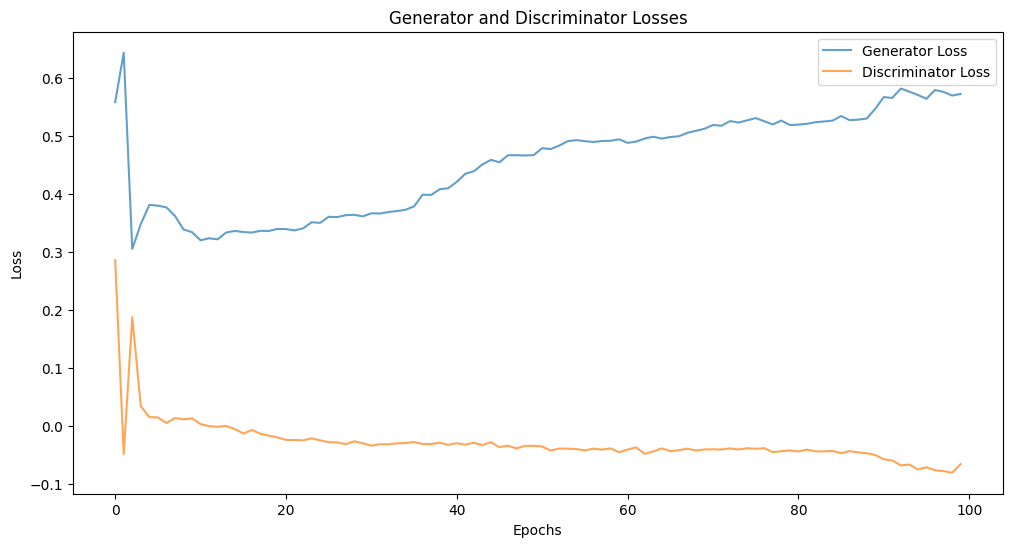

In [98]:
# plot the g_losses and d_losses over epochs
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12, 6))
plt.plot(g_losses, label='Generator Loss', alpha=0.7)
plt.plot(d_losses, label='Discriminator Loss', alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.legend()
plt.show()

Starting evaluation...
predicted_returns type: <class 'numpy.ndarray'>
predicted_returns shape: (500, 1)
Slice tensor type: <class 'torch.Tensor'>
Slice tensor device: cpu
Detached type: <class 'torch.Tensor'>
CPU tensor type: <class 'torch.Tensor'>
real_returns type: <class 'numpy.ndarray'>
real_returns shape: (500, 1)
First 5 real returns: [0.46064404 0.60599285 0.39779708 0.37965658 0.52216375]


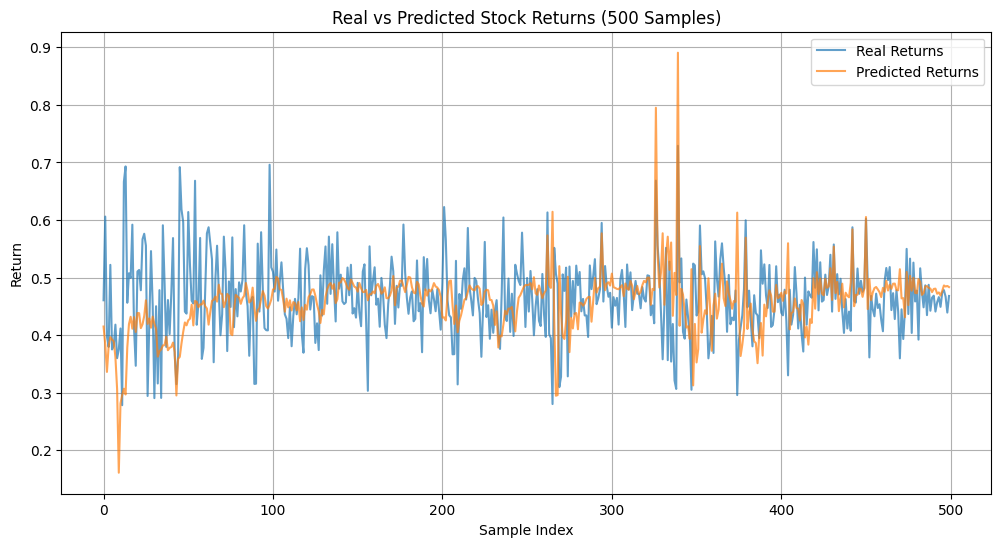

Test MSE: 0.006358
Plot saved and displayed!


In [100]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming generator, factors_tensor, returns_tensor, and device are defined from training
# If not, load them: e.g., factors_tensor = torch.load('synthetic_factors.pt').to(device)

print("Starting evaluation...")

# --- Evaluate and Visualize (Bulletproof Version) ---
generator.eval()
with torch.no_grad():
    test_factors = factors_tensor[:500].to(device)
    predicted_returns = generator(test_factors).detach().cpu().numpy()
    print(f"predicted_returns type: {type(predicted_returns)}")  # Should be <class 'numpy.ndarray'>
    print(f"predicted_returns shape: {predicted_returns.shape}")  # (500, 1)

    # Fixed assignment with () and error handling
    try:
        slice_tensor = returns_tensor[:500]
        print(f"Slice tensor type: {type(slice_tensor)}")  # <class 'torch.Tensor'>
        print(f"Slice tensor device: {slice_tensor.device}")

        detached = slice_tensor.detach()  # Call the method
        print(f"Detached type: {type(detached)}")  # <class 'torch.Tensor'>

        cpu_tensor = detached.cpu()
        print(f"CPU tensor type: {type(cpu_tensor)}")  # <class 'torch.Tensor'>

        real_returns = cpu_tensor.numpy()  # Convert to NumPy
        print(f"real_returns type: {type(real_returns)}")  # <class 'numpy.ndarray'>
        print(f"real_returns shape: {real_returns.shape}")  # (500, 1)

        # Test slicing to confirm
        print(f"First 5 real returns: {real_returns[:5].flatten()}")

    except AttributeError as e:
        print(f"AttributeError caught: {e}")
        print("Fix: Ensure .detach() has parentheses! Falling back to direct conversion.")
        real_returns = returns_tensor[:500].detach().cpu().numpy()  # One-liner fix
    except Exception as e:
        print(f"Unexpected error: {type(e).__name__}: {str(e)}")
        # Minimal fallback (assumes CPU)
        real_returns = returns_tensor[:500].detach().numpy()

# Now plot (only if real_returns is a NumPy array)
if isinstance(real_returns, np.ndarray):
    plt.figure(figsize=(12, 6))
    plt.plot(real_returns.flatten(), label='Real Returns', alpha=0.7)  # Flatten for 1D plot
    plt.plot(predicted_returns.flatten(), label='Predicted Returns', alpha=0.7)
    plt.title('Real vs Predicted Stock Returns (500 Samples)')
    plt.xlabel('Sample Index')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.savefig('returns_comparison_500.png', dpi=300, bbox_inches='tight')
    plt.show()

    # MSE
    mse = np.mean((real_returns - predicted_returns) ** 2)
    print(f"Test MSE: {mse:.6f}")
    print("Plot saved and displayed!")
else:
    print(f"real_returns is still invalid (type: {type(real_returns)}). Check the try block output above.")